## Balanced Extraction and Gap Filling on SWOT Data

**Balanced Extraction on SWOT data**
This notebook extracts the balanced component of SWOT data and fills gaps using a Gaussian Process. The notebook loads and processes the SWOT KaRIn and Nadir data and performs the balanced extraction. Physical and Spectral space plots are included. 

The notebook uses JWS_SWOT_toolbox which requires a Julia install with packages: ```FFTW, Interpolations, LinearAlgebra, Printf, ProgressMeter```. 

In [1]:
import jws_swot_tools as swot
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from jws_swot_tools.julia_bridge import julia_functions as jl

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


┌ Warning: CHOLMOD version incompatibility
│ 
│ Julia was compiled with CHOLMOD version 4.0.4. It is
│ currently linked with version 5.3.1.
│ This might cause Julia to terminate when working with
│ sparse matrix factorizations, e.g. solving systems of
│ equations with \.
│ 
│ It is recommended that you use Julia with the same major
│ version of CHOLMOD as the one used during the build, or
│ download the generic binaries from www.julialang.org,
│ which ship with the correct versions of all dependencies.
└ @ SparseArrays.CHOLMOD ~/miniconda3/envs/d3/share/julia/stdlib/v1.10/SparseArrays/src/solvers/cholmod.jl:206


In [2]:
# Config. 
# -------------------------
data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/' 

pass_number = 9
lat_min = 28 #32 #29
lat_max = 35 #38 #35
index = 6 # Time index to perform the extraction on

# return the files in the data directory for the specified pass number
# karin_files, nadir_files are sorted by cycle and contain the same cycles
_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_number)

# Returns indexes for the Karin and Nadir data between lat_min and lat_max 
sample_index = 2 # some file we use to build the arrays in case the first one hsa NaNs
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims = [len(shared_cycles), track_length, track_length_nadir]

In [3]:
# Init the data classes
# -------------------------
karin, nadir = swot.init_swot_arrays(dims, lat_min, lat_max, pass_number)

# Load and process Karin data
swot.load_karin_data(karin_files, lat_min, lat_max, karin, verbose=False)
swot.process_karin_data(karin)

# Load and process Nadir data
swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir)
swot.process_nadir_data(nadir)

# Detrend using KaRIn spatial mean and check the KaRIn-Nadir bias
karin_mean_t = np.nanmean(karin.ssha, axis=(1, 2))
karin.ssha = karin.ssha - karin_mean_t[:, None, None]
nadir.ssha = nadir.ssha - karin_mean_t[:, None]
# relative_bias = np.nanmean(nadir.ssha[index]) - np.nanmean(karin.ssha[index])
# print(relative_bias)

# Builds the coordinate grids -- in [m]
karin.coordinates()
nadir.coordinates()

# Compute spectra
karin.compute_spectra()
nadir.compute_spectra()

/home/jskinner1/SWOT_tools/src/jws_swot_tools/import_and_process.py:288: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varts = np.nanvar(ssha_array, axis=(1, 2))


Overall SSH variance (overall_var): 0.017270098252846422
----------------------------------
Total Number of Good KaRIn strips : 186
Number of Quality Masked KaRIn strips : 127
Number of High Variance strips removed : 0
Number of Good Cycles: 93
Number of Cycles dropped (>20% masked): 2
----------------------------------

Number of good nadir cycles: 95
Number of bad nadir cycles: 0


/scratch/jskinner1/job_45298101/ipykernel_1487915/762162684.py:14: RuntimeWarning: Mean of empty slice
  karin_mean_t = np.nanmean(karin.ssha, axis=(1, 2))


X grid range (km): 0.00 to 256.41 (span: 256.41 km)
Y grid range (km): 0.00 to 797.81 (span: 797.81 km)
Track Length: 797.81 km
Swath Width: 128.20 km
Karin spacing: dx = 2.00 km, dy = 2.00 km
Nadir spacing: dy = 6.85 km
Computing KaRIn spectra...
Computing Nadir spectra...


/scratch/jskinner1/job_45298101/ipykernel_1487915/682027505.py:7: RuntimeWarning: Mean of empty slice
  ssh_mean = np.nanmean(karin.ssha[n, :, :], axis=0)
/scratch/jskinner1/job_45298101/ipykernel_1487915/682027505.py:8: RuntimeWarning: Mean of empty slice
  nad_mean = np.nanmean(nadir.ssha[n, :])


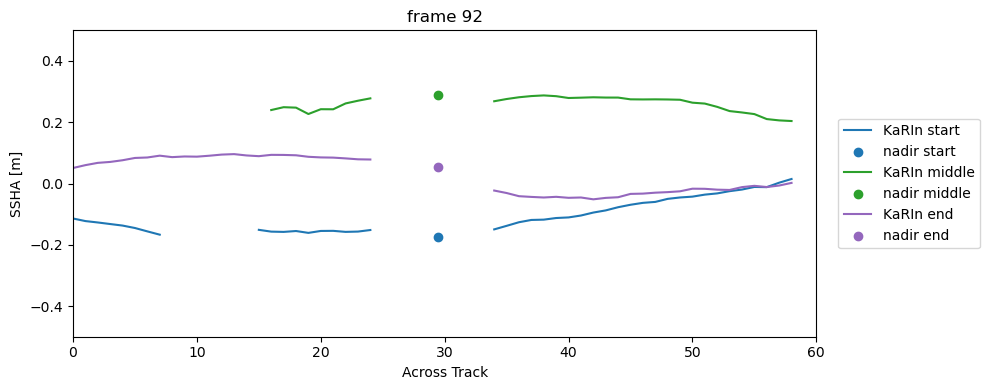

In [4]:
## Diagnostic check of the across track SSHA 
num_frames = 93
fig, ax = plt.subplots(figsize=(10, 4))

for n in range(num_frames):
    ax.clear()
    ssh_mean = np.nanmean(karin.ssha[n, :, :], axis=0)
    nad_mean = np.nanmean(nadir.ssha[n, :])
    ax.plot(karin.ssha[n, 0, :], color ="tab:blue", label= "KaRIn start")
    ax.scatter(29.5, nadir.ssha[n, 0], color ="tab:blue", label = "nadir start")
    ax.plot(karin.ssha[n, int(karin.track_length/2), :], color ="tab:green", label= "KaRIn middle")
    ax.scatter(29.5, nadir.ssha[n, int(nadir.track_length/2)], color ="tab:green", label = "nadir middle")
    ax.plot(karin.ssha[n, int(karin.track_length)-1, :], color ="tab:purple", label= "KaRIn end")
    ax.scatter(29.5, nadir.ssha[n, int(nadir.track_length)-1], color ="tab:purple", label = "nadir end")
    
    ax.set_ylim(-0.5, 0.5)
    ax.set_title(f"frame {n}")
    ax.set_ylabel("SSHA [m]")
    ax.set_xlabel("Across Track")
    ax.set_xlim(0, 60)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    frame_path = f"./scratch/frame_{n:04d}.png"
    plt.tight_layout()
    fig.savefig(frame_path, dpi=150)

plt.show()


---- KaRIn spectrum parameters ----
Amp. balanced   :   2.5969e+04 ± 2.63e+02
lambda balanced :   2.2317e+02 ± 1.58e+00
slope balanced  :   4.6841e+00 ± 5.73e-02
Amp. noise      :   4.0667e+01 ± 3.92e+01
lambda noise    :   1.0001e+02 ± 5.84e+01
slope noise     :   1.7535e+00 ± 2.61e-02


---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 326.1484554342377 ± 1.54e+01



(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>],
       dtype=object))

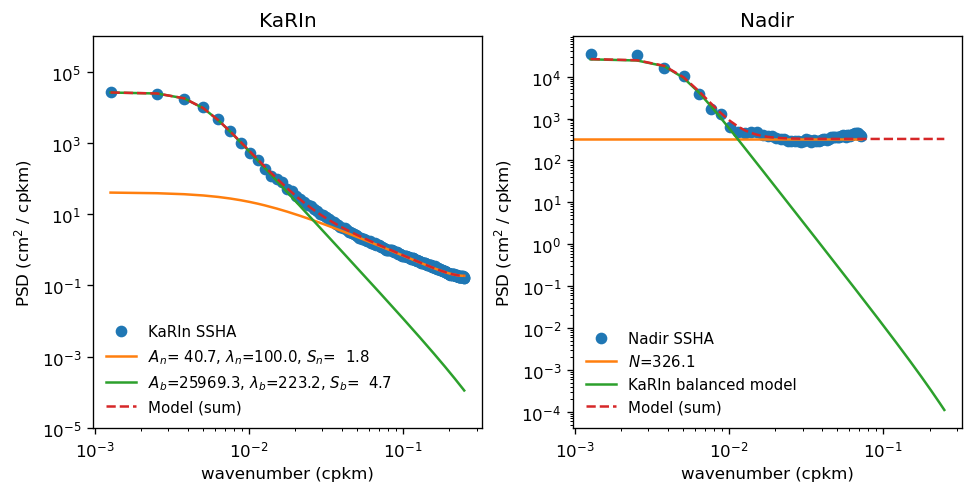

In [5]:
# Spectral Model Fits
# -------------------------
# KaRIn model fit
p_karin, _ = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
p_nadir, _ = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, p_karin)

# Plot the fits
swot.plot_spectral_fits(karin, nadir, p_karin, p_nadir)

In [6]:
# Geometry & masks
# -------------------------
mask_k = np.isfinite(karin.ssha[index])
mask_n = np.isfinite(nadir.ssh[index]).ravel()
    
xkk = (karin.x_grid[mask_k].ravel(order="C")) * 1e-3  # km
ykk = (karin.y_grid[mask_k].ravel(order="C")) * 1e-3
xnn = (nadir.x_grid.ravel()[mask_n]) * 1e-3
ynn = (nadir.y_grid.ravel()[mask_n]) * 1e-3

# Target grid (km)
xt, yt, nxt, nyt, _, _ = swot.make_target_grid(karin, unit="km", extend=False)
n_t = xt.size

r_kk = swot.pairwise_r(xkk, ykk)
r_nn = swot.pairwise_r(xnn, ynn) 
r_kn = swot.pairwise_r(xkk, ykk, xnn, ynn)
r_tk = swot.pairwise_r(xt, yt, xkk, ykk)
r_tn = swot.pairwise_r(xt, yt, xnn, ynn) 
r_tt = swot.pairwise_r(xt, yt)
print("Distance matrices built")

Distance matrices built


In [7]:
# Build covariance functions with spectral taper G and T
# -------------------------
RHO_L_KM = 0 # scale [km] of Gaussian smoothing on covariances

B_psd   = swot.balanced_psd_from_params(p_karin)                # B(k) balanced power spectrum model
Nk_psd  = swot.karin_noise_psd_from_params(p_karin)             # N_K(k) noise power spectrum model
sigma_n = np.sqrt(p_nadir[0] / (2.0 * nadir.dy_km))  # cm

n_samples = 100000
l_sample = 5000
kk = np.arange(n_samples // 2 + 1) / l_sample                  # wavenumber grid for transforms
dk = kk[1] - kk[0]
kmax = kk.max()
print(f"Wavenumber spacing dk = {dk:.6e} cpkm")
print(f"Maximum wavenumber kmax = {kmax:.6e} cpkm")

rho   = 2 * np.pi * RHO_L_KM                           # ρ for Gaussian smooth
delta = (np.pi * karin.dx_km) / (2 * np.log(2))        # δ for taper

# Gaussian and taper
G  = lambda k: np.exp(-((rho**2) * (k**2)) / 2.0)                        # Gassian smooth C[BG]
T  = lambda k: np.exp(-((delta**2) * (k**2)) / 2.0)                      # Taper C[BT]
G2 = lambda k: np.exp(-(rho**2) * (k**2))                    
GT = lambda k: np.exp(-(((rho**2 + delta**2)* k**2) / 2.0) ) 
T2 = lambda k: np.exp(-(delta**2) * (k**2))                    

# Compute covariances using transforms in Julia
C_B      = jl.cov(B_psd(kk), kk)                                         # C[B]
C_BT     = jl.cov(jl.abel(jl.iabel(B_psd(kk), kk) * T(kk), kk), kk)      # C[BT]
C_BG     = jl.cov(jl.abel(jl.iabel(B_psd(kk), kk) * G(kk), kk), kk)      # C[BT]
C_BG2    = jl.cov(jl.abel(jl.iabel(B_psd(kk),  kk) * G2(kk), kk), kk)    # C[BG^2]
C_BTG    = jl.cov(jl.abel(jl.iabel(B_psd(kk),  kk) * GT(kk), kk), kk)    # C[BGT]
C_BT2    = jl.cov(jl.abel(jl.iabel(B_psd(kk) + Nk_psd(kk),  kk) * T2(kk), kk), kk)    # C[BT^2]   

Wavenumber spacing dk = 2.000000e-04 cpkm
Maximum wavenumber kmax = 1.000000e+01 cpkm
Cosine Transform
Variance from spectrum:   125.571186
Variance from covariance: 125.571186
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


Cosine Transform
Variance from spectrum:   125.515857
Variance from covariance: 125.515857
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


Cosine Transform
Variance from spectrum:   125.551478
Variance from covariance: 125.551478
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


Cosine Transform
Variance from spectrum:   125.551478
Variance from covariance: 125.551478
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


Cosine Transform
Variance from spectrum:   125.515857
Variance from covariance: 125.515857
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


Cosine Transform
Variance from spectrum:   126.154772
Variance from covariance: 126.154772


In [8]:
# -------------------------
# Construct blocks
# -------------------------
# Observation terms
R_KK = np.asarray(C_BT2(r_kk), dtype=np.float64) # KaRIn-KaRIn
R_NN = np.asarray(C_B(r_nn)) + (sigma_n**2) * np.eye(r_nn.shape[0], dtype=np.float64) # Nadir–Nadir: C[B] + σ_N^2 
R_KN = np.asarray(C_BT(r_kn), dtype=np.float64)  # KaRIn-Nadir
R_NK = R_KN.T              

# Target terms 
R_tt = np.asarray(C_BG2(r_tt), dtype=np.float64) # Target-Target
R_tK = np.asarray(C_BTG(r_tk), dtype=np.float64) # Target-KaRIn    
R_tN = np.asarray(C_BG(r_tn), dtype=np.float64)  # Target-Nadir 

Compute the Choleksy Factorization

In [9]:
# Assemble observation covariance and compute Cholesky factorization
# -------------------------
include_nadir = True # switch for using/not using the nadir measurements

if include_nadir: 
    C_obs = np.block([[R_KK, R_KN],
                  [R_NK, R_NN]])
    R = np.concatenate([R_tK, R_tN], axis=1)
else: 
    C_obs = R_KK
    R = R_tK

cho = la.cho_factor(C_obs, lower=True)

In [10]:
# Extraction 
# -------------------------
h_k = karin.ssha[index][mask_k].ravel()*100     # in [cm]
h_n = nadir.ssha[index][mask_n]*100             # in [cm]

if include_nadir:
    h_obs = np.concatenate([h_k, h_n])
else: 
    h_obs = h_k 

# Solve for the field
z = la.cho_solve(cho, h_obs)  # (C_obs)^{-1} @ h_obs
ht = R @ z
ht_map = (ht / 100.0).reshape(nyt, nxt).T  # back to [m]

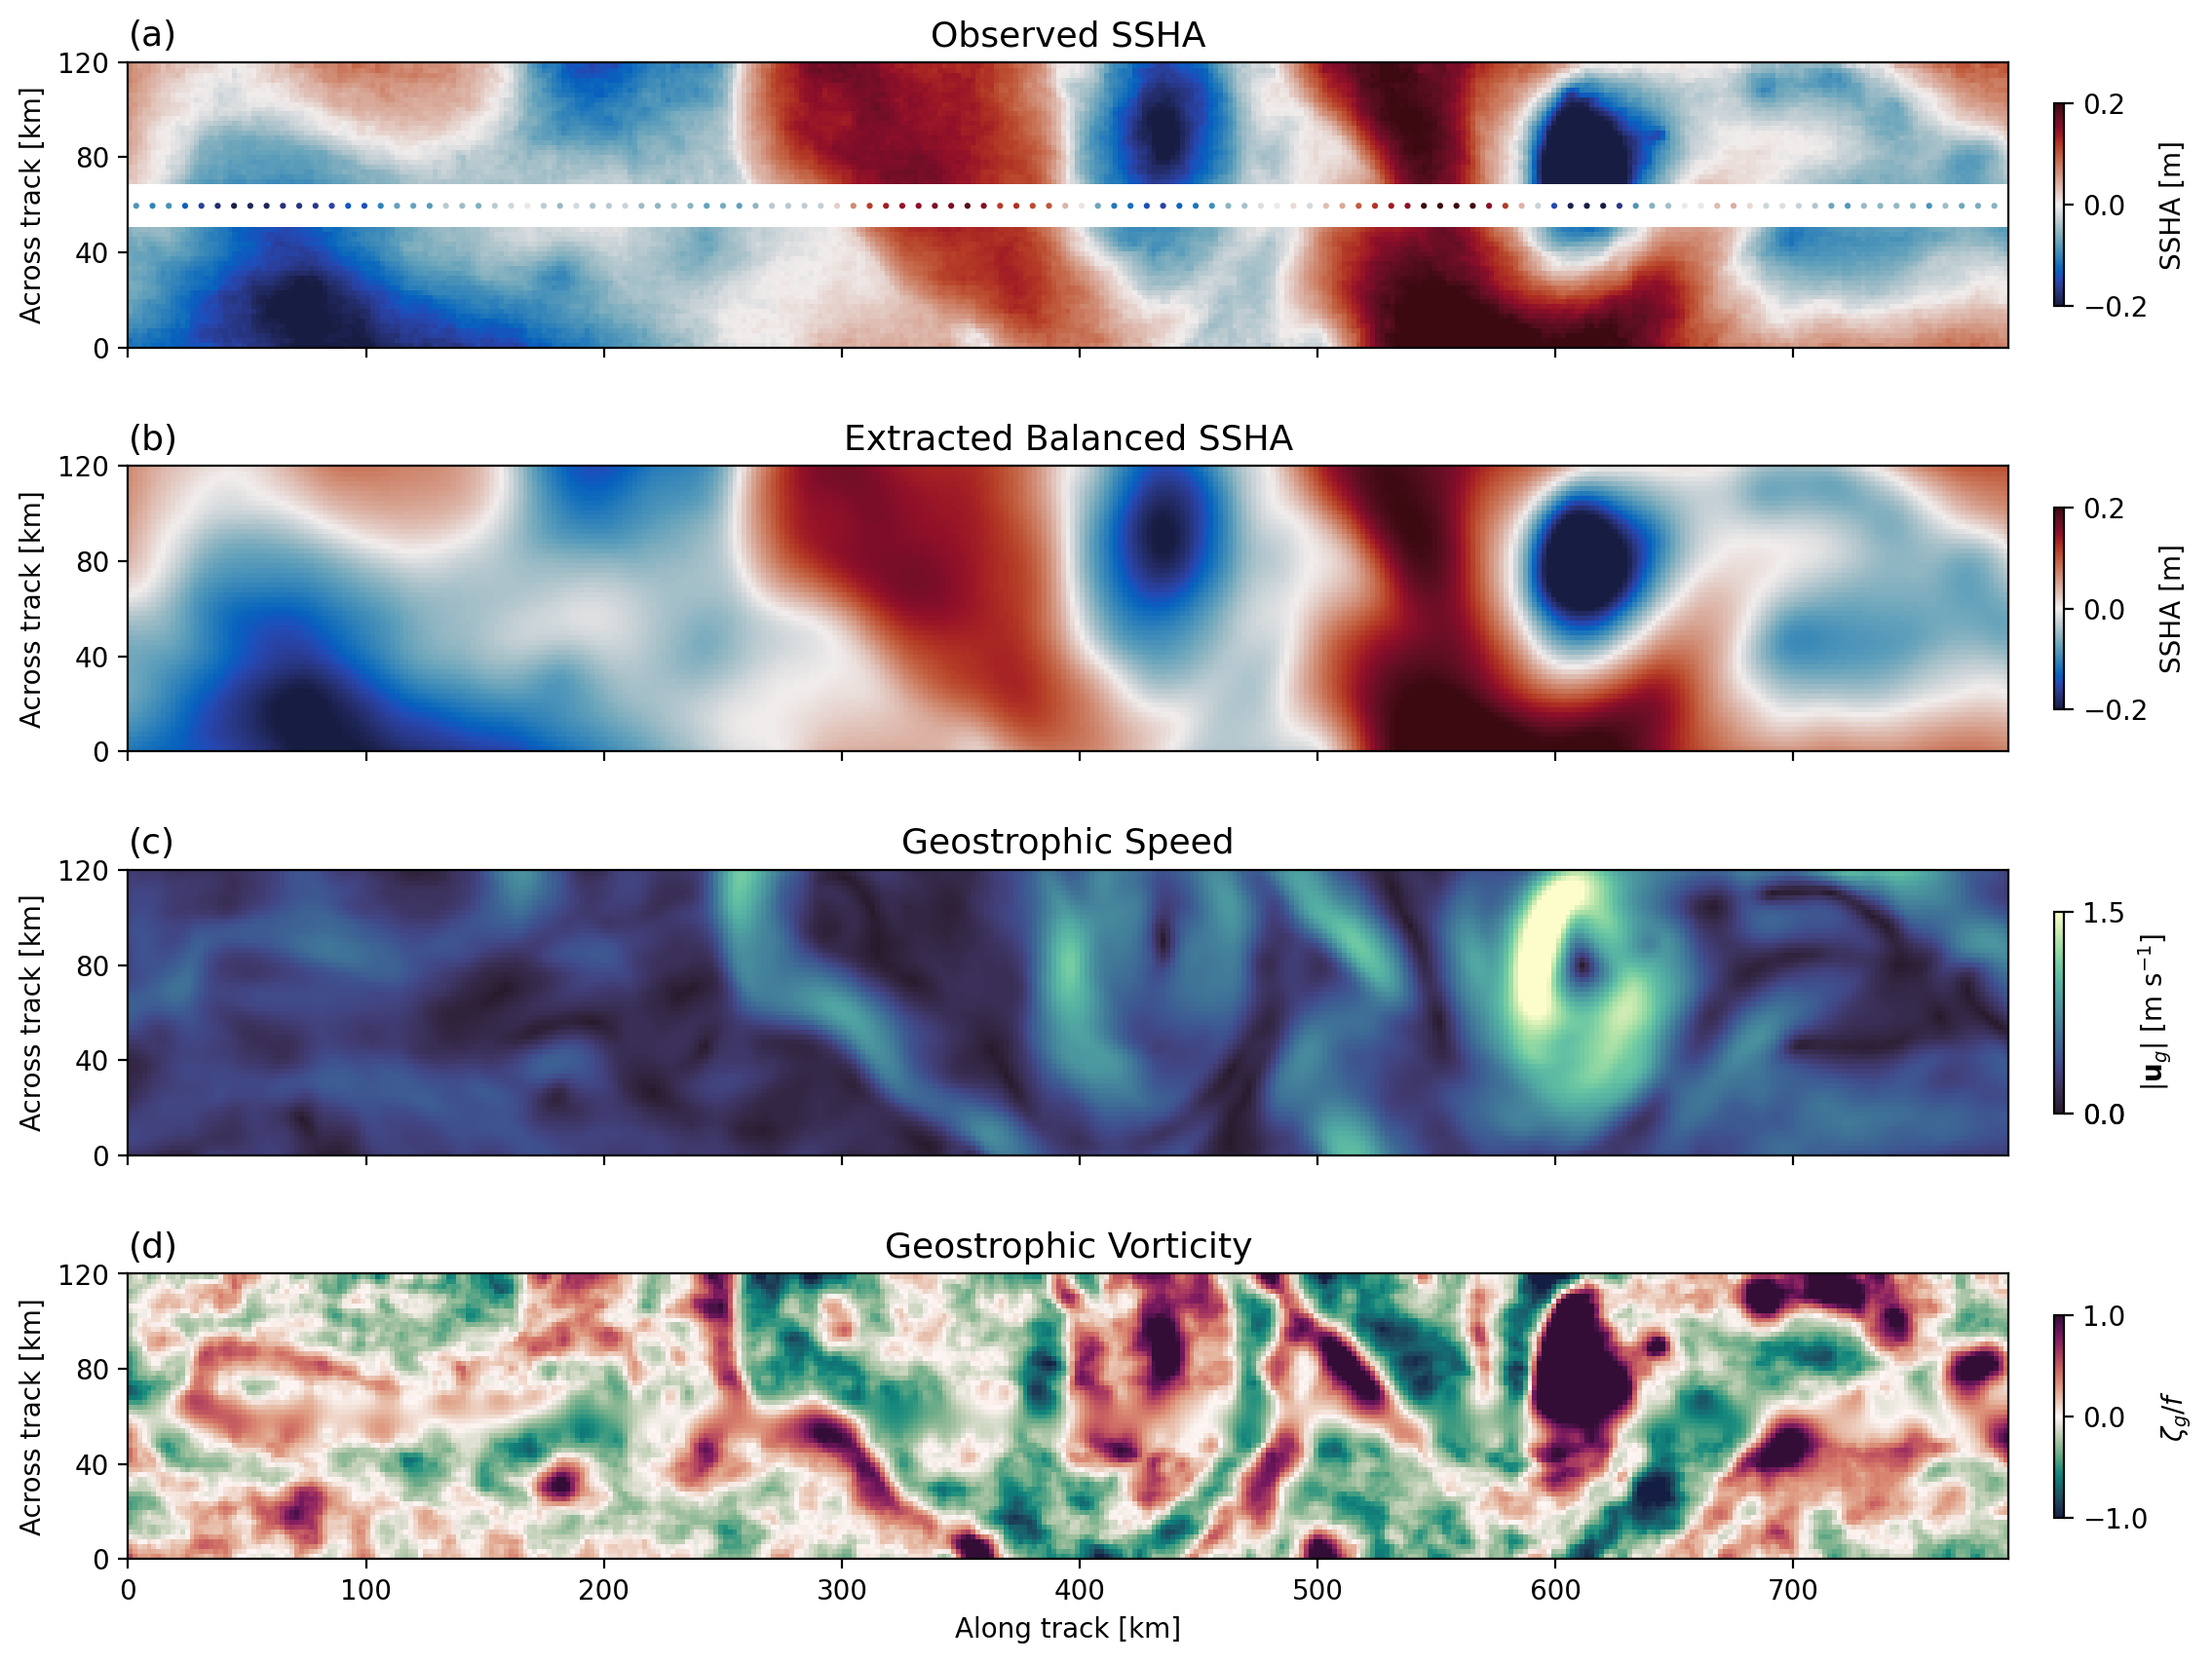

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import importlib
importlib.reload(swot)
from scipy.ndimage import gaussian_filter
from matplotlib import rcParams

rcParams['axes.unicode_minus'] = True

def fmt_minus(x, ndp=1):
    s = f"{x:.{ndp}f}"
    return s.replace("-", "−")

dx_km = float(karin.dy) * 1e-3
dy_km = float(karin.dx) * 1e-3
vmin, vmax = -0.20, 0.20

x_km = np.linspace(0, nyt * karin.dx * 1e-3, ht_map.shape[1])
y_km = np.linspace(0, nxt * karin.dy * 1e-3, ht_map.shape[0])
extent = [0, x_km.max(), 0.0, 119.5]

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True, gridspec_kw={"hspace": 0.4}, dpi=200)

x_grid_k = karin.x_grid
y_grid_k = karin.y_grid

mask_k_2d = np.isfinite(karin.ssha[index])
mask_n_1d = np.isfinite(nadir.ssha[index])

x_n_valid = nadir.x_grid[mask_n_1d]
y_n_valid = nadir.y_grid[mask_n_1d]
ssh_n_valid = nadir.ssha[index][mask_n_1d]


im0 = axes[0].imshow(karin.ssha[index].T, origin="upper", cmap='cmo.balance', aspect="equal",
                    extent=extent, vmin=vmin, vmax=vmax)

if include_nadir:
    axes[0].scatter(
        y_n_valid * 1e-3, (x_n_valid * 1e-3) + 0.5,
        c=ssh_n_valid, s=5, cmap='cmo.balance',
        vmin=vmin, vmax=vmax, edgecolor="none",
        rasterized=True
    )
axes[0].set_title("Observed SSHA", fontsize=13)
axes[0].set_ylabel("Across track [km]")
axes[0].margins(x=0, y=0)
axes[0].set_ylim(0, y_km.max())
axes[0].set_xlim(0, x_km.max())
axes[0].set_aspect("equal")

cbar0 = fig.colorbar(im0, ax=axes[0], shrink=0.7, pad=0.02)
cbar0.set_ticks([vmin, 0, vmax])
cbar0.set_ticklabels([fmt_minus(vmin), "0.0", fmt_minus(vmax)])
cbar0.set_label(r'SSHA [m]')

lats  = np.nanmean(karin.lat_full, axis=0)[5:64]    
eta = np.asarray(ht_map, dtype=float)
dx_m = float(karin.dx)  
dy_m = float(karin.dy)

geo_vort = swot.compute_geostrophic_vorticity(eta, dx_m, dy_m, lats, order=2)
ug, vg, geo_vel = swot.compute_geostrophic_velocity(eta, dx_m, dy_m, lats, order=2)

grad_vmin, grad_vmax = 0.0, 1.5
vort_vmin, vort_vmax = -1.0, 1.0

ht_plot = np.ma.masked_invalid(np.clip(ht_map, vmin, vmax))
geo_vel_plot = np.ma.masked_invalid(np.clip(geo_vel, grad_vmin, grad_vmax))
geo_vort_plot = np.ma.masked_invalid(np.clip(geo_vort, vort_vmin, vort_vmax))

im0 = axes[1].imshow(
    ht_plot, origin="upper", extent=extent,
    cmap='cmo.balance', vmin=vmin, vmax=vmax, rasterized=True
)
axes[1].set_title("Extracted Balanced SSHA", fontsize=13)
axes[1].set_ylabel("Across track [km]")
axes[1].set_aspect("equal")
cbar1 = fig.colorbar(im0, ax=axes[1], shrink=0.7, pad=0.02)
cbar1.set_ticks([vmin, 0, vmax])
cbar1.set_ticklabels([fmt_minus(vmin), "0.0", fmt_minus(vmax)])
cbar1.set_label(r'SSHA [m]')

im1 = axes[2].imshow(
    geo_vel_plot, origin="upper", extent=extent,
    cmap='cmo.deep_r', vmin=grad_vmin, vmax=grad_vmax, rasterized=True
)
axes[2].set_title(r"Geostrophic Speed", fontsize=13)
axes[2].set_ylabel("Across track [km]")
axes[2].set_aspect("equal")
cbar2 = fig.colorbar(im1, ax=axes[2], shrink=0.7, pad=0.02)
cbar2.set_ticks([grad_vmin, 0, grad_vmax])
cbar2.set_ticklabels([fmt_minus(grad_vmin), "0.0", fmt_minus(grad_vmax)])
cbar2.set_label(r'$|\mathbf{u}_g|$ [m s$^{-1}$]')

im2 = axes[3].imshow(
    geo_vort_plot, origin="upper", extent=extent,
    cmap='cmo.curl', vmin=vort_vmin, vmax=vort_vmax, rasterized=True
)
axes[3].set_title("Geostrophic Vorticity", fontsize=13)
axes[3].set_xlabel("Along track [km]")
axes[3].set_ylabel("Across track [km]")
axes[3].set_aspect("equal")

cbar3 = fig.colorbar(im2, ax=axes[3], shrink=0.7, pad=0.02)
cbar3.set_ticks([vort_vmin, 0, vort_vmax])
cbar3.set_ticklabels([fmt_minus(vort_vmin), "0.0", fmt_minus(vort_vmax)])
cbar3.set_label(r'$\zeta_g / f$')

panels = ["(a)", "(b)", "(c)", "(d)"]
for i, ax in enumerate(axes):
    ax.set_title(panels[i], loc='left', fontsize=13)

yticks = np.arange(0, 121, 40)
for ax in axes:
    ax.set_yticks(yticks)

plt.savefig("balanced_extraction.pdf", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
# Compute the Posterior and Posterior Variance (cell takes a while)
# -------------------------
from scipy.linalg import solve_triangular
L, lower = la.cho_factor(C_obs, lower=True, check_finite=False, overwrite_a=False)
W = solve_triangular(L, R.T, lower=True, check_finite=False, overwrite_b=False)

C_mean = W.T @ W                                        # covariance of posterior mean R @ C_obs^{-1} @ R.T

P = R_tt - C_mean                                       # Posterior covariance

posterior_variance = np.diag(P)
posterior_variance_field = posterior_variance.reshape(nyt, nxt)

print("Cholesky")
L_P = np.linalg.cholesky(P)                             # Cholesky factor of posterior covariance

eps = 1e-10 * np.trace(C_mean) / C_mean.shape[0]        # Cholesky factor of posterior-mean covariance
L_mean = np.linalg.cholesky(C_mean + eps * np.eye(C_mean.shape[0]))

print("Done.")

In [ ]:
# perform diagnostics on the matrixes if needed
# swot.diagnose_not_positive_definite(C_mean)

In [ ]:
# Compute the spectra of the reconstruction, covariance, and posterior samples (Fig. 5)
# -------------------------
import xarray as xr
import xrft

def power_spec_1d(field):
    f2d = np.array(field).reshape((nyt, nxt), order="C")
    da = xr.DataArray(
        f2d[None, :, :],
        coords=[[0], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    spec_xr = swot.mean_power_spectrum(da, karin.window, 'line', ['sample', 'pixel'])
    # Keep positive wavenumbers along-track
    half = int(karin.track_length // 2)
    spec_vals = 2 * spec_xr[half:]  # 2 times for one-sided spectrum
    if spec_vals.size != karin.wavenumbers_cpkm.size:
        spec_vals = spec_vals[:karin.wavenumbers_cpkm.size]
    return np.asarray(spec_vals)

# Posterior draws 
rng = np.random.default_rng(seed=42)
nreal = 50

all_specs            = []  # spectra of posterior samples (mean + ε)
all_specs_uncert     = []  # spectra of ε ~ N(0, P)
all_specs_mean_cov   = []  # spectra of η ~ N(0, C_mean)
eta_list = []
sample_list = []
for _ in range(nreal):
    # Uncertainty draw (ε) and sample = ht + ε
    z   = rng.standard_normal(P.shape[0])
    eps = L_P @ z
    sample = ht + eps
    sample_list.append(sample)

    all_specs.append(power_spec_1d(sample))
    all_specs_uncert.append(power_spec_1d(eps))

    # Posterior-mean covariance draw
    zm = rng.standard_normal(C_mean.shape[0])
    eta = L_mean @ zm
    all_specs_mean_cov.append(power_spec_1d(eta))
    eta_list.append(eta)

# Aggregate the spectra 
all_specs            = np.asarray(all_specs)
all_specs_uncert     = np.asarray(all_specs_uncert)
all_specs_mean_cov   = np.asarray(all_specs_mean_cov)

spec_mean              = np.nanmean(all_specs, axis=0)
spec_std               = np.nanstd(all_specs, axis=0)
spec_median            = np.nanmedian(all_specs, axis=0)
spec_mean_uncertainty  = np.nanmean(all_specs_uncert, axis=0)
spec_mean_of_mean      = np.nanmean(all_specs_mean_cov, axis=0)

print("Done")

In [ ]:
def plot_spectrum_comparison(karin_obj, swot_obj, ht_map_2d):
    k_karin = karin_obj.wavenumbers_cpkm[int(karin_obj.track_length/2):]
    karin_spec_sample_mean = karin_obj.spec_alongtrack_av[int(karin_obj.track_length/2):]
    k_karin_sliced = k_karin[1:]

    nx_dim = ht_map_2d.shape[1] # Along-track 
    ny_dim = ht_map_2d.shape[0] # Across-track  
    ht_map_coords = {
        'pixel': np.arange(0, ny_dim) * karin_obj.dy_km, # Across-track 
        'line': np.arange(0, nx_dim) * karin_obj.dx_km   # Along-track 
    }
    ht_map_xr = xr.DataArray((ht_map_2d - np.mean(ht_map_2d)), coords=ht_map_coords, dims=['pixel', 'line'])
    spec_ht_map_2s = swot_obj.mean_power_spectrum(ht_map_xr, karin_obj.window, 'line', ['pixel'])
    spec_ht_map = spec_ht_map_2s[int(karin_obj.track_length/2):][1:]
    spec_k_ins = karin.spec_alongtrack_ins[index][int(karin_obj.track_length/2):][1:]

    fig, axs = plt.subplots(1, 1, figsize=(5.5, 4.5), dpi=150, constrained_layout=True)
    k_km = k_karin_sliced 
    
    axs.loglog(k_km, spec_k_ins, color='tab:blue', label='KaRIn SSHA')
    axs.loglog(k_km, spec_ht_map , '-', lw=2, color='black',label='Extracted SSH (posterior mean)')
    axs.loglog(k_km[:], 0.5*spec_mean_uncertainty[1:], color='tab:red', label = 'Posterior uncertainty')
    axs.loglog(k_km[:], 0.5*spec_mean_of_mean[1:],color='tab:green', label = 'Posterior mean covariance')

    #axs.loglog(k_km[:], 0.5*spec_mean_of_mean[1:] + 0.5*spec_mean_uncertainty[1:],color='tab:purple', label = 'Sum')

    separation_scale_km = 38
    separation_wavenumber = 1/separation_scale_km 
    axs.axvline(x=separation_wavenumber, color='grey', linestyle='-', lw=1.0, alpha = 0.5)
    text_label = f'{separation_scale_km:.0f} km'
    ymin, ymax = axs.get_ylim()
    y_pos = 1e4
    axs.text(separation_wavenumber * 1.1, y_pos, text_label, rotation=90,color='dimgrey',fontsize=10,verticalalignment='center',horizontalalignment='left')

    # separation_scale_km = 71
    # separation_wavenumber = 1/separation_scale_km 
    # axs.axvline(x=separation_wavenumber, color='grey', linestyle='-', lw=1.0, alpha = 0.5)
    # text_label = f'{separation_scale_km:.0f} km'
    ymin, ymax = axs.get_ylim()
    y_pos = 1e4
    axs.text(separation_wavenumber * 1.1, y_pos, text_label,rotation=90, color='dimgrey', fontsize=10, verticalalignment='center', horizontalalignment='left')
    axs.set_xlabel('Wavenumber [cpkm]')
    axs.set_ylabel('Power spectral density [cm$^2$cpkm$^{-1}$]')
    axs.set_xlim(1e-3, 3e-1)
    axs.set_ylim(1e-5, 1e7)
    axs.legend(loc='lower left',frameon=True,facecolor='white',edgecolor='none',framealpha=1.0,fontsize=11)
    
    plt.savefig('balanced_spectrum.pdf', bbox_inches='tight')
    plt.show()

ht_map = ht.reshape(nyt, nxt).T 
plot_spectrum_comparison(karin_obj=karin,swot_obj=swot,ht_map_2d=ht_map)

In [ ]:
H, W = karin.ssha[index].shape
gap = 25
sw  = karin.swath_width

mask2d = np.isfinite(karin.ssha[index])
col_all_bad = ~np.any(mask2d, axis=0)   
mask2d[:, col_all_bad] = True           

striped_mask = np.ones((H, W), dtype=bool)

i = 0
toggle = True
while i < H:
    if toggle:
        striped_mask[i:i+gap, :] = mask2d[i:i+gap, :]
        i += gap
    else:
        striped_mask[i:i+sw, :] = True
        i += sw
    toggle = not toggle

eta_list_array = np.array(eta_list)
sample_map_list = eta_list_array.reshape(-1, nyt, nxt).transpose(0, 2, 1) / 100
sample_map = sample_map_list[10]
#sample_map = np.where(striped_mask.T, sample_map, np.nan)

geo_vort_sample = swot.compute_geostrophic_vorticity(
    np.ma.masked_invalid(sample_map),   # SSH [cm]
    2000, 2000,                         # dx, dy in meters
    lats,                               # 2D latitude array
    order=2
)

_, _, vel_sample = swot.compute_geostrophic_velocity(
    np.ma.masked_invalid(sample_map),
    2000, 2000,
    lats,
    order=2
)


fig, axs = plt.subplots(3, 1, figsize=(13, 6), dpi=150, constrained_layout=True)

extent = [0, sample_map.shape[1]*2, 0, sample_map.shape[0]*2]   # 2 km resolution → km scale

# SSH
im0 = axs[0].imshow(sample_map, origin='lower', extent=extent, aspect='auto', cmap='cmo.balance')
axs[0].set_title("Posterior Sample SSH")
plt.colorbar(im0, ax=axs[0])

# |u|
im1 = axs[1].imshow(vel_sample, origin='lower', extent=extent, aspect='auto', cmap='cmo.deep_r')
axs[1].set_title("Geostrophic Speed")
plt.colorbar(im1, ax=axs[1])

# Vorticity
im2 = axs[2].imshow(geo_vort_sample, origin='lower', extent=extent, aspect='auto', cmap='cmo.curl')
axs[2].set_title("Geostrophic Vorticity")
plt.colorbar(im2, ax=axs[2])

# Axis labels
for ax in axs:
    ax.set_ylabel("Across-track [km]")
axs[2].set_xlabel("Along-track [km]")

plt.show()


In [ ]:
# Sample from the posterior 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cmocean

eta_list_array = np.array(eta_list)                     
sample_map_list = eta_list_array.reshape(-1, nyt, nxt)  
sample_map_list = sample_map_list.transpose(0, 2, 1)    
sample_map_list = sample_map_list / 100.0              
nsamples, ny, nx = sample_map_list.shape

geo_vort_list = np.zeros_like(sample_map_list)
speed_list    = np.zeros_like(sample_map_list)

for i in range(nsamples):
    sample_map = sample_map_list[i]

    geo_vort = swot.compute_geostrophic_vorticity(
        np.ma.masked_invalid(sample_map),
        2000, 2000,
        lats,
        order=2
    )

    _, _, vel = swot.compute_geostrophic_velocity(
        np.ma.masked_invalid(sample_map),
        2000, 2000,
        lats,
        order=2
    )

    geo_vort_list[i] = geo_vort
    speed_list[i]    = vel


extent = [0, nx * 2, 0, ny * 2]   # 2 km grid spacing -> km

ssh_vmin, ssh_vmax   = np.nanpercentile(sample_map_list, [1, 99])
spd_vmin, spd_vmax   = np.nanpercentile(speed_list, [1, 99])
vort_vmin, vort_vmax = np.nanpercentile(geo_vort_list, [1, 99])

fig, axs = plt.subplots(3, 1, figsize=(13, 6), dpi=150, constrained_layout=True)

im0 = axs[0].imshow(sample_map_list[0], origin='lower', extent=extent,
                    aspect='auto', cmap=cmocean.cm.balance,
                    vmin=ssh_vmin, vmax=ssh_vmax)
axs[0].set_title("Posterior Sample SSH")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(speed_list[0], origin='lower', extent=extent,
                    aspect='auto', cmap=cmocean.cm.deep_r,
                    vmin=spd_vmin, vmax=spd_vmax)
axs[1].set_title("Geostrophic Speed")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(geo_vort_list[0], origin='lower', extent=extent,
                    aspect='auto', cmap=cmocean.cm.curl,
                    vmin=vort_vmin, vmax=vort_vmax)
axs[2].set_title("Geostrophic Vorticity")
plt.colorbar(im2, ax=axs[2])

for ax in axs:
    ax.set_ylabel("Across-track [km]")
axs[2].set_xlabel("Along-track [km]")

def update(frame):
    im0.set_data(sample_map_list[frame])
    im1.set_data(speed_list[frame])
    im2.set_data(geo_vort_list[frame])

    axs[0].set_title(f"Posterior Sample SSH (frame {frame})")
    axs[1].set_title(f"Geostrophic Speed (frame {frame})")
    axs[2].set_title(f"Geostrophic Vorticity (frame {frame})")

    return im0, im1, im2

anim = FuncAnimation(fig, update, frames=nsamples, interval=200, blit=False)

plt.show()

anim.save("posterior_samples.mp4", fps=5, dpi=150)
print("done")